**TextRank**

In [1]:
import numpy as np
from collections import Counter
import re
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

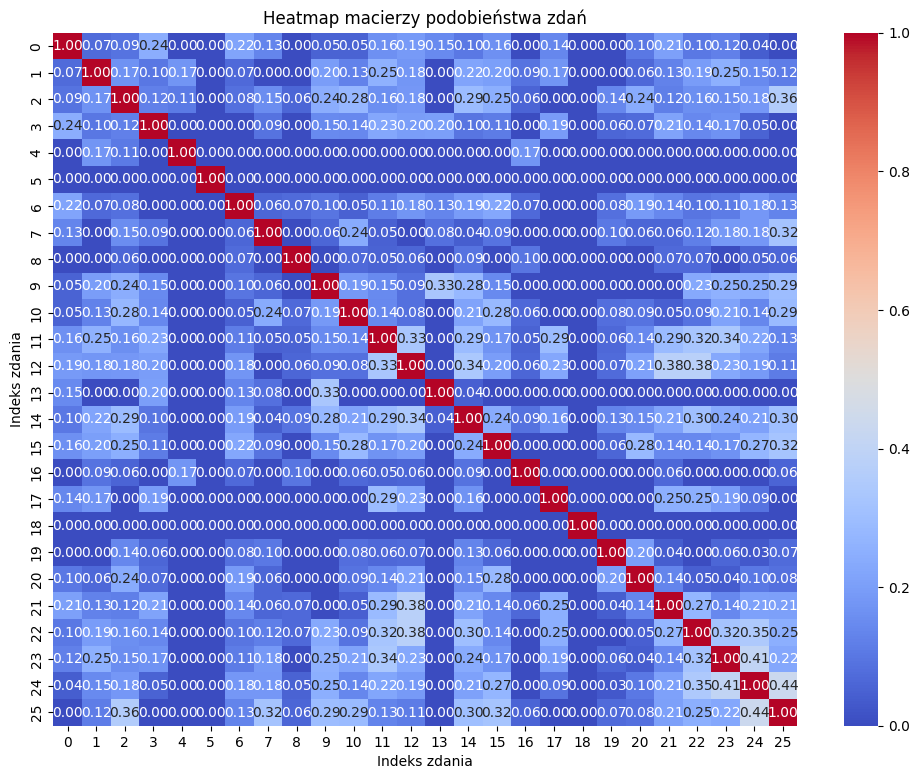

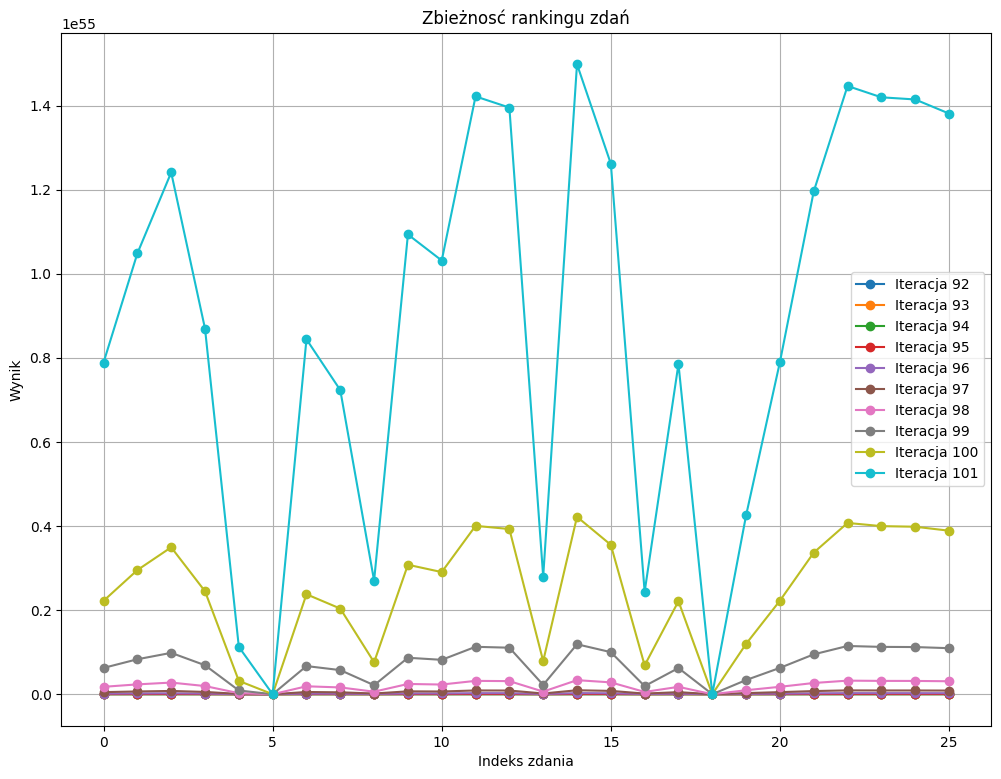

Summary: But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue


In [2]:
class TokenizeSentence:
    def tokenize(self, text):
        # oddzielamy tekst po . ! lub ?
        sentences = re.split(r'[.?!]+', text)
        # usuwamy puste stringi, obcinamy białe znaki
        return [s.strip() for s in sentences if s.strip()]

# metoda Bag Of Words
class Vectorize:
    # przyjmuje tokenized sentences i przeksztalca w wektory
    def to_vector(self, sentences):
        # tworzymy zbiór unikalnych słów ze wszystkich zdań
        unique_words = set()
        for s in sentences:
            # konwersja na male litery i podział na słowa
            unique_words.update(s.lower().split())
        self.words_list = list(unique_words)
        vectors = []
        for s in sentences:
            word_counts = Counter(s.lower().split())
            # wektor dla zdania; każdy element odpowiada liczbie wystąpień danego słowa
            vectors.append([word_counts.get(word, 0) for word in self.words_list])
        # tutaj kazzdy wiersz reprezentuje wektor jednego zdania
        return np.array(vectors)

class TextRank:
    def __init__(self, damping=0.85, iter_limit=100, err=1e-8):
        self.damping = damping # wspolczynnik tlumienia, zazwyczaj na poziomie 0.85
        self.iter_limit = iter_limit
        self.err = err

    # oblicza podobieństwo kosinusowe między dwoma wektorami
    def cosine_similarity(self, vec1, vec2):
        dot_multiply = np.dot(vec1, vec2)
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)
        return dot_multiply / (norm_vec1 * norm_vec2) if norm_vec1 and norm_vec2 else 0

     # buduje macierz podobieństwa na podstawie listy wektorów ze zdaniami
    def similarity_matrix(self, vectors):
        n = len(vectors)
        sim_m = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                similarity = self.cosine_similarity(vectors[i], vectors[j])
                # symetryczne elementy macierzy uzupelniamy wartościami podobienstwa
                sim_m[i, j] = sim_m[j, i] = similarity
        return sim_m

    # ranking zdan na podstawie macierzy podobieństwa
    def score_sentences(self, sim_matrix):
        n = sim_matrix.shape[0]
        scores = np.ones(n)
        score_history = [scores.copy()]
        for _ in range(self.iter_limit):
            new_scores = (1 - self.damping) + self.damping * np.dot(sim_matrix, scores)
            score_history.append(new_scores.copy())
            # checkk czy różnica między nowymi a starymi wynikami jest mniejsza niż tolerancja?
            if np.linalg.norm(new_scores - scores) < self.err:
                break
            scores = new_scores
        return scores, score_history

    def similarity_mat(self, sim_matrix):
        plt.figure(figsize=(12, 9))
        sns.heatmap(sim_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Heatmap macierzy podobieństwa zdań')
        plt.xlabel('Indeks zdania')
        plt.ylabel('Indeks zdania')
        plt.show()

    def score_convergence(self, score_history, it_step=20):
        plt.figure(figsize=(12, 9))
        iterations_to_plot = range(len(score_history)-10, (len(score_history)))
        for i in iterations_to_plot:
            plt.plot(score_history[i], marker='o', label=f'Iteracja {i+1}')
        plt.title('Zbieżnosć rankingu zdań')
        plt.xlabel('Indeks zdania')
        plt.ylabel('Wynik')
        plt.legend()
        plt.grid(True)
        plt.show()



    # tworzymy podsumowanie tekstu wybierając najlepiej ocenione zdania
    def summarize(self, sentences, vectors):
        sim_m = self.similarity_matrix(vectors)
        scores, score_history = self.score_sentences(sim_m)
        ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        summary = ' '.join([el[1] for el in ranked_sentences[:5]])
    
        self.similarity_mat(sim_m)
        self.score_convergence(score_history)

        return summary
    

file_path = "C:/Users/blasz/OneDrive/Pulpit/BBC_News_Summary/t10/bs001.txt"
with open(file_path, 'r') as file:
    text = file.read()

token = TokenizeSentence()
sentences = token.tokenize(text)

vector = Vectorize()
sentence_vectors = vector.to_vector(sentences)

textrank = TextRank()
summary = textrank.summarize(sentences, sentence_vectors)

print("Summary:", summary)

**SVM**

In [3]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

folder_a = "C:/Users/blasz/OneDrive/Pulpit/BBC_News_Summary/t10"
folder_s = "C:/Users/blasz/OneDrive/Pulpit/BBC_News_Summary/ts10"

# tworzymy pary do treningu - (artykul, podsumowanie)
def load_data(folder_a, folder_s):
    data_pairs = []
    for filename in os.listdir(folder_a):
        article_path = os.path.join(folder_a, filename)
        summary_path = os.path.join(folder_s, filename)
        if os.path.exists(summary_path):  
            with open(article_path, 'r', encoding='utf-8') as file:
                article_text = file.read()
            with open(summary_path, 'r', encoding='utf-8') as file:
                summary_text = file.read()
            data_pairs.append((article_text, summary_text))
    return data_pairs


class Vectorize:
    def __init__(self):
        self.words_list = []

    def build_vocab(self, all_sentences):
        unique_words = set()
        for sentences in all_sentences:
            for s in sentences:
                unique_words.update(s.lower().split())
        self.words_list = list(unique_words)

    def to_vector(self, sentences):
        vectors = []
        for s in sentences:
            word_counts = Counter(s)
            vectors.append([word_counts.get(word, 0) for word in self.words_list])
        return np.array(vectors)


class LinearSVM(nn.Module):
    def __init__(self, input_dim):
        super(LinearSVM, self).__init__() 
        self.weights = nn.Parameter(torch.randn(input_dim, 1)) # wagi do trenowania
        self.bias = nn.Parameter(torch.zeros(1)) # biasy do trenowania

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias # przewidywanie modelu; liniowa kombinacja wejscia i wag

def hinge_loss(outputs, labels):
    # utrata zawiasow na podstawie wyjscia modelu i etykeit
    #jest minimalizowana, gdy wszystkie przyklady są poprawnie sklasyfikowane
    return torch.mean(torch.clamp(1 - labels * outputs, min=0))

def train_svm(model, features, labels, epochs=100, learning_rate=0.01):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)  
    # przeksztalcamy listy cech i etykiet na tensory Pytorch
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad() # resetujemy gradienty
        outputs = model(features) # wyniki modelu
        loss = hinge_loss(outputs, labels)
        loss.backward() # propagacja wsteszna błędów
        optimizer.step() # aktualizujemy parametry modelu
        
        if epoch % 10 == 0:
            print(f"Epoka {epoch}, Strata: {loss.item()}")
            losses.append(loss.item())
            
    return model, losses


data_pairs = load_data("C:/Users/blasz/OneDrive/Pulpit/BBC_News_Summary/t10", "C:/Users/blasz/OneDrive/Pulpit/BBC_News_Summary/ts10")
texts = [pair[0] for pair in data_pairs] 
summaries = [pair[1] for pair in data_pairs]  

tokenizer = TokenizeSentence()
sentences = [tokenizer.tokenize(text) for text in texts]

vectorizer = Vectorize()
all_sentences = [tokenizer.tokenize(text) for text in texts]
vectorizer.build_vocab(all_sentences) 

vectors = np.vstack([vectorizer.to_vector(sentence) for sentence in all_sentences])

labels = np.ones(len(vectors))
input_dim = vectors.shape[1]
model = LinearSVM(input_dim)
train_svm(model, vectors, labels)


Epoka 0, Strata: 0.0410604365170002
Epoka 10, Strata: 0.031432487070560455
Epoka 20, Strata: 0.02196447364985943
Epoka 30, Strata: 0.014049931429326534
Epoka 40, Strata: 0.010183801874518394
Epoka 50, Strata: 0.008385012857615948
Epoka 60, Strata: 0.006718079559504986
Epoka 70, Strata: 0.0050794873386621475
Epoka 80, Strata: 0.0034318435937166214
Epoka 90, Strata: 0.0017630006186664104


(LinearSVM(),
 [0.0410604365170002,
  0.031432487070560455,
  0.02196447364985943,
  0.014049931429326534,
  0.010183801874518394,
  0.008385012857615948,
  0.006718079559504986,
  0.0050794873386621475,
  0.0034318435937166214,
  0.0017630006186664104])

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class VisualizeData:
    def __init__(self, texts, summaries, vectors):
        self.texts = texts
        self.summaries = summaries
        self.vectors = vectors

    def plot_loss_curve(self, losses):
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label='Utrata zawiasów')
        plt.title('Straty treningowe na przestrzeni epok')
        plt.xlabel('Epoki')
        plt.ylabel('Straty')
        plt.legend()
        plt.show()

    def plot_feature_weights(self, weights):
        plt.figure(figsize=(10, 5))
        sns.histplot(weights.detach().numpy(), bins=30, kde=True)
        plt.title('Rozkład wag cech')
        plt.xlabel('Wartość wagi')
        plt.ylabel('Częstotliwość')
        plt.show()

    def plot_pca(self):
        """Principal Component Analysis (analiza głównych składowych) - identyfikuje glowne skladowe danych, ktore
        są kierunkami w danych wielowymiarowych gdzi ejest najwieksza wariancja"""
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(self.vectors)
        
        plt.figure(figsize=(8, 8))
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
        plt.title('PCA danych wektorowych')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()

    def plot_tsne(self):
        """redukuje wymiarowosc do dwoch lub trzech wymiarow; 
        punkty podobne w przestrzeni wielowymiarowej beda blisko siebie w przestrzeni niskowymiarowej, 
        a te różne będą daleko od siebie"""
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(self.vectors)
        
        plt.figure(figsize=(8, 8))
        plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
        plt.title('t-SNE Danych wektorowych')
        plt.xlabel('Wymiar 1')
        plt.ylabel('Wymiar 2')
        plt.show()


Epoka 0, Strata: 0.0010356103302910924
Epoka 10, Strata: 0.000706908933352679
Epoka 20, Strata: 0.00037853606045246124
Epoka 30, Strata: 5.049144965596497e-05
Epoka 40, Strata: 0.0
Epoka 50, Strata: 0.0
Epoka 60, Strata: 0.0
Epoka 70, Strata: 0.0
Epoka 80, Strata: 0.0
Epoka 90, Strata: 0.0


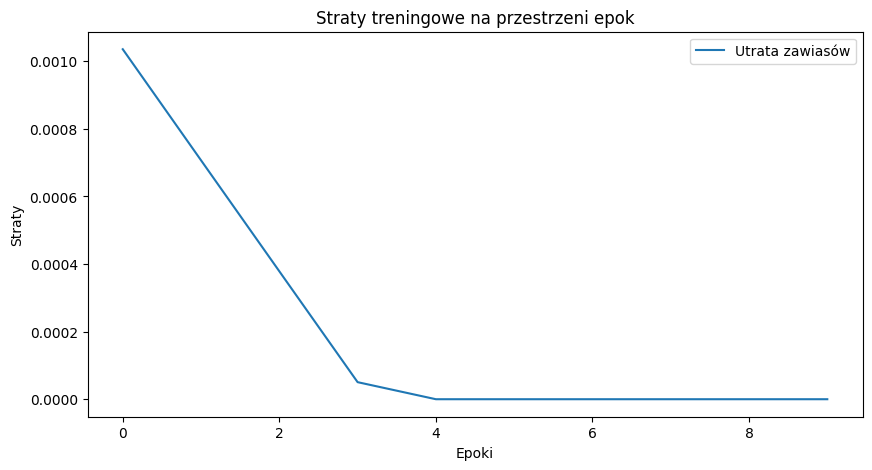

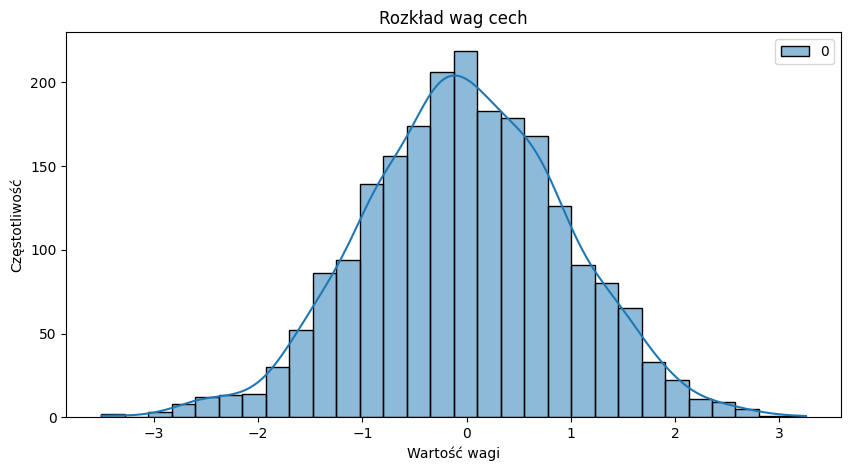

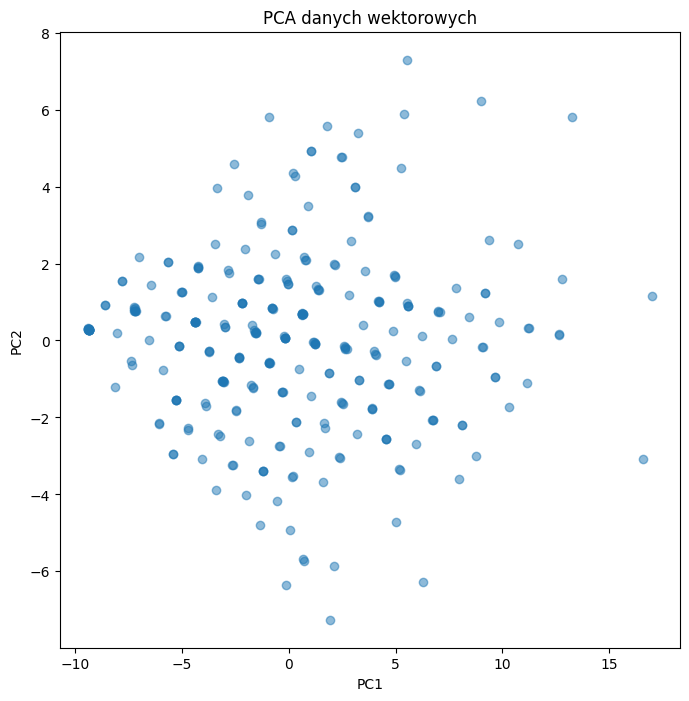

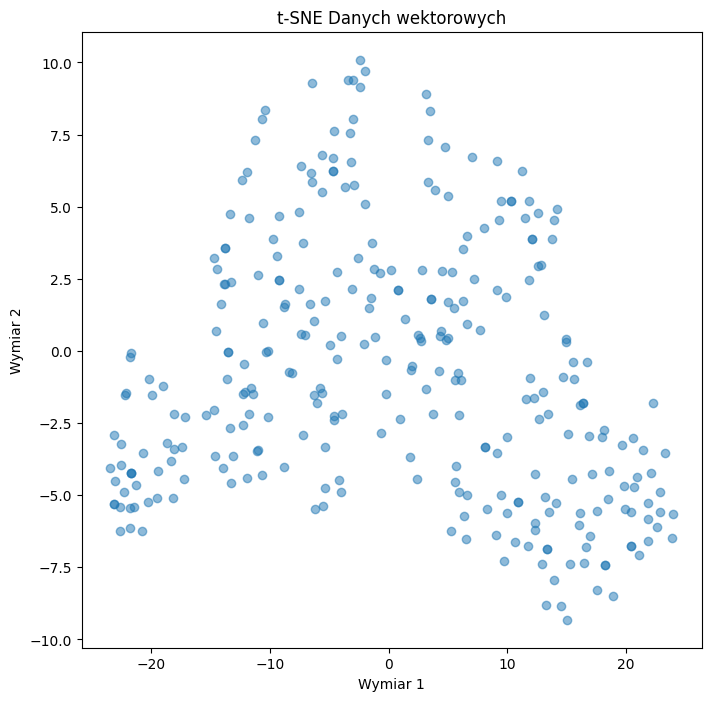

In [5]:
visualizer = VisualizeData(texts, summaries, vectors)
trained_model, losses = train_svm(model, vectors, labels)
visualizer.plot_loss_curve(losses)
visualizer.plot_feature_weights(trained_model.weights)
visualizer.plot_pca()
visualizer.plot_tsne()
